In [173]:
import excelreader
import numpy.random as rd
import numpy as np
import random
import matplotlib.pyplot as plt

In [174]:
helper = excelreader.ProblemHelper()

Matrice originale des choix ordonnés par etudiant :
---------------------------------------------------
MAELLE ANDRICQUE........... :  1  2  2  1  2  1  2  3  1  3  2  3  1  3  3  3  1  1
OMAR KHALIFA ARIF.......... :  1  3  3  3  1  3  2  3  1  3  3  3  2  3  3  3  3  3
ALBANE ARTHUIS............. :  1  2  3  3  3  2  1  3  3  2  3  3  1  3  3  3  1  1
HOUSSAM BAHHOU............. :  3  3  3  2  3  2  1  3  1  1  3  1  3  1  2  3  3  3
LUCIE BANNAY............... :  3  3  3  2  3  3  2  3  3  3  3  3  3  3  3  3  1  3
REMI BARBOSA............... :  3  3  3  2  3  2  1  2  1  2  3  1  2  2  3  3  3  3
MARGOT BEAUREPAIRE......... :  3  3  3  2  2  3  2  2  2  1  3  1  3  1  3  3  2  2
BAPTISTE BENARD............ :  3  3  2  2  3  3  2  3  3  2  2  2  3  3  3  3  1  3
HAMZA BENMENDIL............ :  3  3  3  2  3  2  1  3  1  1  3  1  3  1  3  3  3  3
AYMERIC BLED............... :  2  3  3  1  3  1  2  2  1  1  2  2  3  1  3  3  3  3
ROMAIN BONNEFON............ :  3  3  3  3  3  2  2  2  2

In [175]:
id_industies = [1, 7]

In [176]:
NB_OF_CHROMOSOME = 100
NB_OF_LOOP = 2000
MUTATION = 0.2
DECREASE_MUTATION = 2          # divis 
NB_ALLOW_TOBE_PARENT = 50
MUTATION_PROPABILITY = 0.15

In [177]:
MALUS_GRP_1 = 2500
MALUS_GRP_3 = 2500
MALUS_GRP_4 = 1000
MALUS_GRP_5SUP = 10000

MALUS_MIXITE = 800

MALUS_CHOICE_2 = 500
MALUS_CHOICE_3 = 1500

MALUS_INDUSTRY = 2500

In [178]:
def getProjectChoiceByStudent(student, project):
    studentName = helper.matrixStudentNumberToName()[student]
    return helper._originalWishes[studentName][project]

In [179]:
def createRandomChromosome(nbOfStudent, nbOfProject):
    return [rd.randint(0,nbOfProject) for _ in range(nbOfStudent)]

def chromosomeChild(parent1, parent2):
    aChromosome = []
    for i in range(len(parent1[0])):
        if(rd.random() > 0.5):
            aChromosome.append(parent1[0][i])
        else:
            aChromosome.append(parent2[0][i])
    if(rd.random() < MUTATION_PROPABILITY):
        chromosomeMutation(aChromosome)

    return aChromosome

def chromosomeMutation(aChromosome):
    index = rd.randint(len(aChromosome))
    val = aChromosome[index]
    aChromosome[index] = (val+1)%2
    return aChromosome

def computeFitness(aChromosome, nbOfProject):
    fitess = 0

    occurence_proj = [[] for i in range(nbOfProject)]
    for stud in range(len(aChromosome)):
        occurence_proj[aChromosome[stud]].append(helper._studentsGroup[stud])
    
    for proj in occurence_proj:
        # nbStud par proj
        if len(proj) == 1: fitess += MALUS_GRP_1
        elif len(proj) == 3:  fitess += MALUS_GRP_3
        elif len(proj) > 4: fitess += MALUS_GRP_5SUP
        # mixité
        if proj.count('EMMK') > 1 or proj.count('ENSC') > 1: fitess += MALUS_MIXITE

    # rang proj pour chaque stud
    for stud in range(len(aChromosome)):
        studChoice = getProjectChoiceByStudent(stud, aChromosome[stud])
        if studChoice == 2: fitess += MALUS_CHOICE_2
        elif studChoice == 3 : fitess += MALUS_CHOICE_3
    
    return fitess

def orderByFitness(chromosomesWithFitness):
    return sorted(chromosomesWithFitness, key=lambda chromosome: chromosome[1])

In [180]:
nbOfStudent = len(helper.matrixStudentNumberToName())
nbOfProject = len(helper.matrixProjectsNumberToName())

chromosomes = [createRandomChromosome(nbOfStudent, nbOfProject) for _ in range(100)]
chromosomesWithFitness = [[chro, computeFitness(chro,nbOfProject)] for chro in chromosomes]

evol = []
for _ in range(NB_OF_LOOP):
    chromosomesWithFitness = orderByFitness(chromosomesWithFitness)
    chromosomesWithFitness = chromosomesWithFitness[0:-NB_OF_MUTATION]
    for _ in range(NB_OF_MUTATION):
        newChromosome = chromosomeChild(random.choices(chromosomesWithFitness[50:])[0],random.choices(chromosomesWithFitness[50:])[0])
        newChroFitness = computeFitness(newChromosome,nbOfProject)
        chromosomesWithFitness.append([newChromosome, newChroFitness])
    evol.append(chromosomesWithFitness[0][1])


In [188]:
bestConfig = np.array(chromosomesWithFitness[0][0])
print(tuple(bestConfig))

(0, 12, 17, 11, 3, 8, 16, 2, 4, 0, 13, 4, 6, 9, 6, 3, 11, 11, 8, 13, 9, 11, 8, 0, 12, 9, 5, 13, 7, 17, 6, 7, 16, 9, 13, 8, 0, 6)


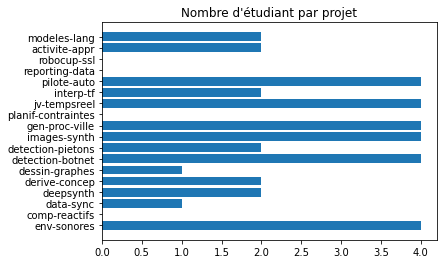

In [183]:
project, nb_stud = np.unique(bestConfig, return_counts=True)
nb_stud = [nb_stud[list(project).index(i)] if (i in project) else 0 for i in range(nbOfProject)]
project = list(range(nbOfProject))
ax = plt.subplot()
ax.barh(project, nb_stud)
ax.set_yticks(project, labels=helper.matrixProjectsNumberToName())
ax.set_title("Nombre d'étudiant par projet")
plt.show()

In [184]:
bestConfig

array([ 0, 12, 17, 11,  3,  8, 16,  2,  4,  0, 13,  4,  6,  9,  6,  3, 11,
       11,  8, 13,  9, 11,  8,  0, 12,  9,  5, 13,  7, 17,  6,  7, 16,  9,
       13,  8,  0,  6])

Numéro qu'a donné chaque étudiant au projet qu'il lui a été attribué:  [1, 2, 1, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2]


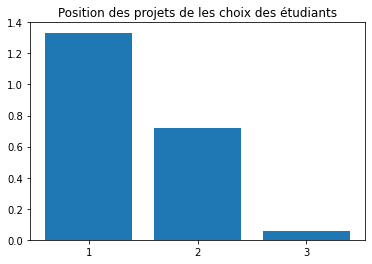

In [185]:
original_choice = [getProjectChoiceByStudent(stud, proj) for stud, proj  in enumerate(bestConfig)]
print("Numéro qu'a donné chaque étudiant au projet qu'il lui a été attribué: ", original_choice)
choice, nbChoice = np.unique(original_choice, return_counts=True)
nbChoice = nbChoice/nbOfProject # normalize
plt.figure()
ax = plt.subplot()
ax.bar(choice, nbChoice)
ax.set_xticks(choice, labels=choice)
ax.set_title("Position des projets de les choix des étudiants")
plt.show()

Fitness finale: 19400


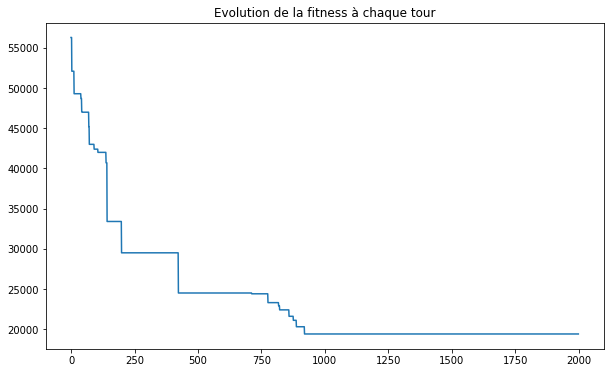

In [186]:
print("Fitness finale:", evol[-1])
plt.figure(figsize=(10,6))
plt.plot(range(NB_OF_LOOP), evol)
plt.title("Evolution de la fitness à chaque tour")
plt.show()